In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import random

In [3]:
class ES():
    def __init__(self, domain, dim, population_size, offspring_size, fitness, max_iter, plus=False, parent_random=False):
        assert population_size <= offspring_size
        if type(domain) is tuple:
            self.domain = np.array([domain] * dim)
        else:
            self.domain = np.array(domain)

        self.dim = dim
        self.mu = population_size
        self.lam = offspring_size
        lr = 1 #K 
        self.tau0, self.tau = lr/np.sqrt(2 * np.sqrt(self.dim)), lr/np.sqrt(2*self.dim)
        self.fitness = fitness
        self.max_iter = max_iter
        self.plus = plus
        if parent_random:
            self.parent_selection = self.parent_selection_random
        else:
            self.parent_selection = self.parent_selection_roulette

    def initial_individual(self):
        x = np.random.uniform(self.domain[:,0], self.domain[:,1], size=self.dim)
        sigma = np.random.uniform(3, 8, size=self.dim)

        return np.vstack((x, sigma))

    def random_individual(self):
        x = np.random.uniform(self.domain[:,0], self.domain[:,1], size=self.dim)
        sigma = np.random.uniform(0.5, 1.5, size=self.dim)

        return np.vstack((x, sigma))

    def generate_population(self, initial=False):
        P = []
        for _ in range(self.mu):
            if initial:
                P.append(self.initial_individual())
            else:
                P.append(self.random_individual())
        P = np.array(P)
        return np.array(P)

    # def mutate(self, P):
    #     xs, sigmas = P[:, 0], P[:, 1]
    #     mutated = []
    #     for i in range(len(P)):
    #         eps0 = np.random.normal(0, self.tau0)
    #         eps = np.random.normal(0, self.tau, size=self.dim)
            
    #         new_sigma = sigmas[i] * np.exp(eps0 + eps)

    #         new_x = xs[i] + np.random.normal(0, new_sigma**2, size=self.dim)
            
    #         its = 0
    #         while (np.any(new_x < self.domain[:,0]) or np.any(new_x > self.domain[:,1])) and its < 4:
    #             its += 1
    #             new_x = xs[i] + np.random.normal(0, new_sigma**2, size=self.dim)
            
    #         if (np.any(new_x < self.domain[:,0]) or np.any(new_x > self.domain[:,1])):
    #             new_x, new_sigma = self.random_individual()
            
    #         mutated.append(np.vstack((new_x, new_sigma)))
    #     return np.array(mutated)

    def mutate(self, P):
        xs, sigmas = P[:, 0], P[:, 1]
        assert type(sigmas) == np.ndarray
        mutated = []

        for i in range(len(P)):
            eps0 = np.random.normal(0, self.tau0**2)
            eps = np.random.normal(0, self.tau**2)
            multiplier = np.exp(eps0 + eps)
            
            new_sigma = sigmas[i] * multiplier

            new_x = xs[i] + np.random.normal(0, new_sigma**2, size=self.dim)
            
            its = 0
            while (np.any(new_x < self.domain[:,0]) or np.any(new_x > self.domain[:,1])) and its < 4:
                its += 1
                new_x = xs[i] + np.random.normal(0, new_sigma**2, size=self.dim)
            
            if (np.any(new_x < self.domain[:,0]) or np.any(new_x > self.domain[:,1])):
                new_x, new_sigma = self.random_individual()
            
            mutated.append(np.vstack((new_x, new_sigma)))
            
        return np.array(mutated)

    def replacement(self, P, P_costs, pc, pc_costs):
        if(self.plus):
            combined = np.concatenate((P, pc), axis=0)
            assert combined.shape == (self.mu + self.lam, 2, self.dim), f"{combined.shape}"
            combined_scores = np.concatenate((P_costs, pc_costs))
            indices = np.argsort(combined_scores)
            assert combined_scores[indices[0]] <= combined_scores[indices[-1]]
            P = combined[indices[:self.mu]]
        else:
            scores = np.array([self.fitness(p[0]) for p in pc])
            indices = np.argsort(scores)
            P = pc[indices[:self.mu]]
        return P

    def parent_selection_random(self, P, score):
        return P[np.random.choice(len(P), self.lam, replace=True)]

    def parent_selection_roulette(self, P, score):
        if np.min(score) == np.max(score):
            idxs = np.random.choice(len(P), size=self.lam, replace=True)
        else:
            std_costs = (score - np.min(score)) / (score - np.min(score)).max()
            p_costs = (1 - std_costs)
            idxs = np.random.choice(len(P), p=p_costs / sum(p_costs), size=self.lam, replace=True)
        return P[idxs].copy()

    def run(self):
        P = self.generate_population(initial=True)
        assert P.shape == (self.mu, 2, self.dim) 
        score = np.array([self.fitness(p[0]) for p in P])
        best_score = np.min(score)
        best_sigma = []
        best_individual = P[np.argmin(score)]

        iter_min, iter_mean, iter_max = [], [], []
        range_ = trange(int(self.max_iter), position=0, leave=True)
        try:
            for _iter in range_:
                parents = self.parent_selection(P, score)
                assert parents.shape == (self.lam, 2, self.dim)

                mutation = self.mutate(parents)
                assert mutation.shape == (self.lam, 2, self.dim)

                P = self.replacement(P, score, mutation, [self.fitness(p[0]) for p in mutation])
                assert P.shape == (self.mu, 2, self.dim), f'{P.shape}'

                score = np.array([self.fitness(p[0]) for p in P])

                min_score_index = np.argmin(score)
                min_score = np.min(score)
                if min_score < best_score:
                    best_score = min_score
                    best_individual = P[min_score_index]
                
                # print(f'Iter: {_iter}, best: {best_score}')
                iter_min.append(np.min(score))
                iter_mean.append(np.mean(score))
                iter_max.append(np.max(score))
                #calculate mean of P[1]:
                best_sigma.append(np.mean(P[:, 1]))
        except KeyboardInterrupt:
            pass

        return best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max


In [4]:
def showcase(best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max, problem_name, global_minima):
    print(f'Best individual: {best_individual[0]}')
    print(f'Best score: {best_score}')
    plt.plot(iter_mean, label='mean')
    plt.plot(iter_min, label='min')
    global_minima_array = np.full(len(iter_min), global_minima)
    plt.plot(global_minima_array, label='min_global', color='r')
    plt.legend()
    plt.title(problem_name)
    plt.show()

    plt.plot(best_sigma, label='sigma')
    plt.title('Sigma')
    plt.show()

def ESPlusRandom(domain, dim, population_size, offspring_size, fitness, max_iter, problem_name, global_minima):
    model = ES(domain, dim, population_size, offspring_size, fitness, max_iter, plus=True, parent_random=True)
    best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max = model.run()
    showcase(best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max, problem_name, global_minima)

def ESPlusRoulette(domain, dim, population_size, offspring_size, fitness, max_iter, problem_name, global_minima):
    model = ES(domain, dim, population_size, offspring_size, fitness, max_iter, plus=True, parent_random=False)
    best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max = model.run()
    showcase(best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max, problem_name, global_minima)

def ESCommaRandom(domain, dim, population_size, offspring_size, fitness, max_iter, problem_name, global_minima):
    model = ES(domain, dim, population_size, offspring_size, fitness, max_iter, plus=False, parent_random=True)
    best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max = model.run()
    showcase(best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max, problem_name, global_minima)

def ESCommaRoulette(domain, dim, population_size, offspring_size, fitness, max_iter, problem_name, global_minima):
    model = ES(domain, dim, population_size, offspring_size, fitness, max_iter, plus=False, parent_random=False)
    best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max = model.run()
    showcase(best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max, problem_name, global_minima)

In [32]:
def calculate_new_domain(domain, A, b, d, h, upper_limit, lower_limit):
    #find max y in R^h that satisfies A*y + b >= -500 where A is matrix of size d x h and b is vector of size d
    right_side = np.full(d, upper_limit) - b 
    max_y = np.linalg.lstsq(A, right_side, rcond=None)[0]

    #find min y in R^h that satisfies A*y + b >= -500 where A is matrix of size d x h and b is vector of size d
    right_side = np.full(d, lower_limit) - b
    min_y = np.linalg.lstsq(A, right_side, rcond=None)[0] 

    pairs = []
    for i in range(h):
        pairs.append((min_y[i], max_y[i]))
    domain = np.array(pairs)
    return domain 

import numpy as np

def calculate_domain_from_h_to_d(domain, A, b, h, d, upper_limit, lower_limit):
    """
    Calculate the new domain from R^h to R^d given a transformation matrix A and vector b.

    Args:
        domain (np.ndarray): The original domain (ignored in this calculation).
        A (np.ndarray): A transformation matrix of size h x d.
        b (np.ndarray): A vector of size h.
        h (int): Dimension of the input space (R^h).
        d (int): Dimension of the output space (R^d).
        upper_limit (float): Upper limit for the inequalities.
        lower_limit (float): Lower limit for the inequalities.

    Returns:
        np.ndarray: An array of shape (d, 2) where each row represents the min and max bounds for each dimension in R^d.
    """
    # Prepare storage for the bounds of each dimension in R^d
    min_bounds = []
    max_bounds = []
    
    for i in range(d):
        # Define the constraints for solving bounds for the i-th dimension in R^d
        e_i = np.zeros(d)
        e_i[i] = 1  # Unit vector to isolate the i-th dimension

        # Solve for max x_i in R^d that satisfies A * x + b <= upper_limit
        upper_constraint = np.full(h, upper_limit) - b
        max_x = np.linalg.lstsq(A, upper_constraint, rcond=None)[0]

        # Solve for min x_i in R^d that satisfies A * x + b >= lower_limit
        lower_constraint = np.full(h, lower_limit) - b
        min_x = np.linalg.lstsq(A, lower_constraint, rcond=None)[0]

        # Extract the bounds for the i-th dimension
        min_bounds.append(min_x[i])
        max_bounds.append(max_x[i])

    # Combine the bounds into pairs (min, max) for each dimension
    domain = np.array(list(zip(min_bounds, max_bounds)))
    return domain


Uzywamy wiecej wymiarow ale mamy mniejsze domeny wiec moze obliczy lepiej? idk

In [34]:
#benchmark 1 Sphere function http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page1113.htm
def Sphere(individual): 
    d = len(individual)
    return np.sum(individual**2)

domain = (-5.12, 5.12)
dims = 50
initial_population = 4000
offspring_size = 21000
iterations = 1

In [32]:
d = dims
h = 2500 * d
A = np.random.rand(d, h)
b = np.random.rand(d)

def SphereWrapper(y):
    x = np.dot(A, y) + b 
    return Sphere(x)
    
domain = calculate_new_domain(domain, A, b, d, h)
print(domain)

[[-0.00655154  0.00658314]
 [-0.00800185  0.00796635]
 [-0.00773713  0.00770629]
 ...
 [-0.00665078  0.006734  ]
 [-0.0083204   0.00812489]
 [-0.00793104  0.00776632]]


  0%|          | 1/4000 [12:28<831:19:29, 748.38s/it]


Best individual mapped back to original space:[ 0.22411462  0.09701355 -0.02173434 -0.2123837   0.09774753 -0.08452745
  0.06791854 -0.13822702 -0.16567203  0.07444898  0.36459053  0.30919882
 -0.6361455  -0.08609982  0.38059054  0.04013378 -0.06538522  0.00628953
 -0.39630256  0.44181559 -0.08771615 -0.3037652  -0.66613134  0.02611824
  0.32745243 -0.03883186 -0.50651834  0.15677311  0.33102227  0.45539735
 -0.32279747  0.34508175 -0.3581974  -0.60068062  0.15131309 -0.11908058
  0.00925477  0.3061658  -0.33268031 -0.13231035 -0.15133529  0.16049412
  0.40397032 -0.3432929  -0.69321704 -0.2379568  -0.04007238 -0.07650059
 -0.32097878 -0.46417205]
4.7377984074862205
Best individual: [ 0.00046144  0.00600142 -0.0048724  ... -0.00378814 -0.0019552
  0.00134744]
Best score: 4.7377984074862205


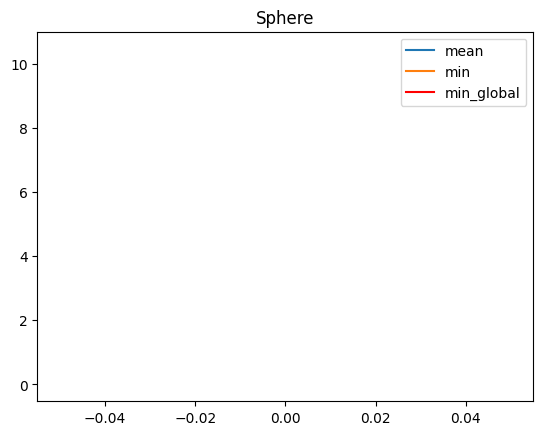

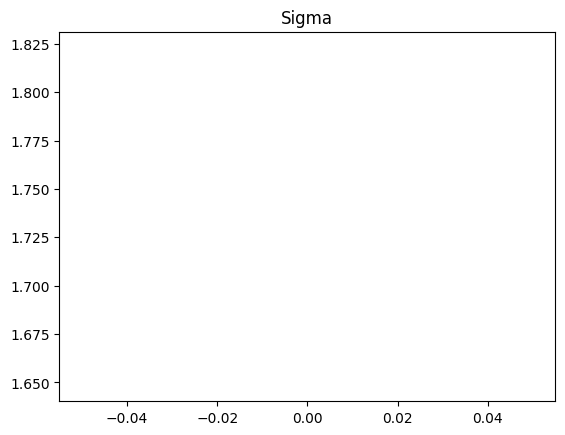

In [33]:
model = ES(domain, h, initial_population, offspring_size, SphereWrapper, iterations, plus=True, parent_random=True)
best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max = model.run()
indiv = np.dot(A, best_individual[0]) + b
print("Best individual mapped back to original space:" + str(indiv))
print(Sphere(indiv))
showcase(best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max, "Sphere", 0)

100%|██████████| 1000/1000 [01:19<00:00, 12.52it/s]

Best individual mapped back to original space:[-0.0415214   0.00278349  0.0503906   0.00804463 -0.04888625  0.05035178
  0.08118728 -0.0025968   0.05910197  0.09257414  0.01289092  0.04823775
  0.07127118  0.04063614 -0.01034412 -0.02323521 -0.08990335 -0.04094094
  0.03350067 -0.03481195 -0.0694947  -0.00334675 -0.03834046 -0.06682667
 -0.03699607 -0.06188772 -0.04693207 -0.0066404   0.03319603  0.05729979]
0.0724930165365649
Best score: 0.0724930165365649


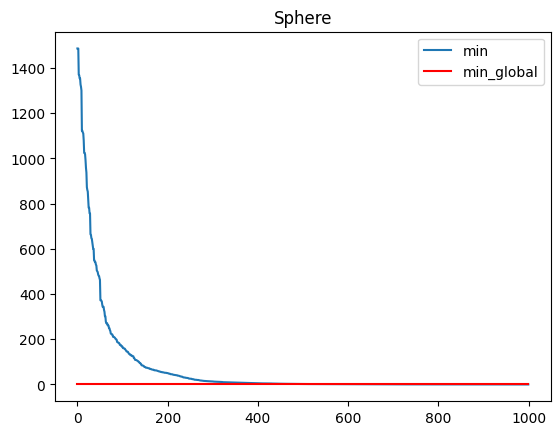

In [135]:
model = ES(domain, h, initial_population, offspring_size, SphereWrapper, iterations, plus=True, parent_random=True)
best_individual, best_score, iter_min, iter_mean, iter_max = model.run()
indiv = np.dot(A, best_individual[0]) + b
print("Best individual mapped back to original space:" + str(indiv))
print(Sphere(indiv))
showcase(best_individual, best_score, iter_min, iter_mean, iter_max, "Sphere", 0)

In [43]:
#benchmark 2 Rastrigin function http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page2607.htm
def Rastrigin(individual):
    d = len(individual)
    return 10*d + np.sum(individual**2 - 10*np.cos(2*np.pi*individual))

domain = (-5.12, 5.12)
dims = 60
initial_population = 100
offspring_size = 700
iterations = 4

In [48]:
d = dims
h = 40000 * d
A = np.random.rand(d, h)
b = np.random.randint(d)

def RastriginWrapper(y):
    x = np.dot(A, y) + b 
    return Rastrigin(x)
domain = calculate_new_domain(domain, A, b, d, h)
print(domain.shape)

(2400000, 2)


 25%|██▌       | 1/4 [07:57<23:51, 477.16s/it]


Best individual mapped back to original space:[ 0.00551243  0.06957801 -0.04644248 -0.13408473 -0.05337168 -0.07302948
  0.16958225  0.04448767 -0.01410743 -0.1097805  -0.0500125  -0.03548883
 -0.01964151  0.04973456 -0.02312189 -0.03372815 -0.12589081  0.07375898
 -0.11175474  0.05300445 -0.02556164  0.03665695 -0.05317146 -0.03922607
  0.03825346 -0.03913363  0.12652291 -0.00477523  0.18491271  0.01141393
 -0.08087169 -0.03752228 -0.01543563  0.07291256  0.12802676  0.05672379
 -0.09784655 -0.08182664 -0.0495172   0.03933944 -0.04165965  0.18678005
 -0.06742488  0.02159819  0.08004068  0.05600591  0.06335998 -0.03896657
  0.25256287 -0.01747302 -0.12096809 -0.06106953  0.03176212  0.091706
  0.08278237 -0.00447949  0.05924604 -0.20613914 -0.11986077 -0.01504246]
82.23075934955637
Best individual: [-0.00018626 -0.00026505  0.00019998 ...  0.00024103  0.00010098
  0.00012949]
Best score: 82.23075934955637


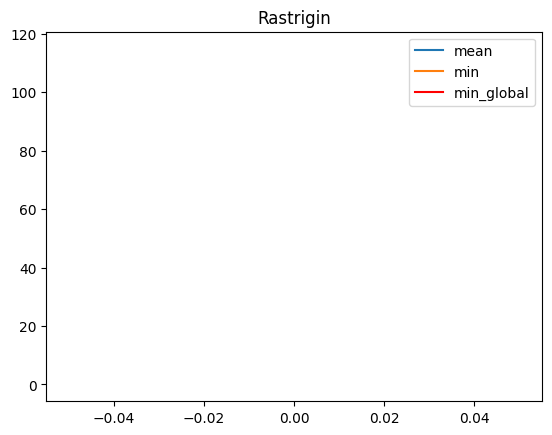

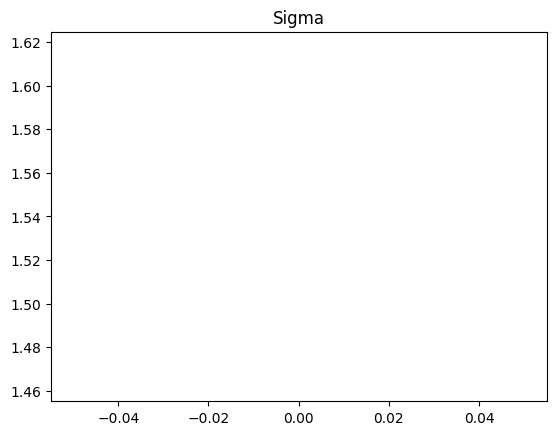

In [49]:
model = ES(domain, h, initial_population, offspring_size, RastriginWrapper, iterations, plus=True, parent_random=False)
best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max = model.run()
indiv = np.dot(A, best_individual[0]) + b
print("Best individual mapped back to original space:" + str(indiv))
print(Rastrigin(indiv))
showcase(best_individual, best_sigma, best_score, iter_min, iter_mean, iter_max, "Rastrigin", 0)

 77%|███████▋  | 773/1000 [08:38<02:32,  1.49it/s]

Best individual mapped back to original space:[ 5.56807785e+00 -5.98699618e+00  3.14187998e+00  9.20861011e-02
  2.96564150e+00 -2.71322157e+00  3.42362988e+00  7.63688884e+00
  1.51095141e+00  2.83328788e+00 -1.34892324e+01 -4.77897730e+00
 -9.00059840e-01  5.98790318e+00  3.97386432e+00 -3.47098150e+00
  1.50624583e+00 -3.68349013e+00  3.99547971e+00 -4.91430322e+00
 -6.00252374e-01 -7.04911535e-01 -1.93769072e+00 -4.99029142e+00
  4.80737734e-01 -1.23380500e+00 -3.15547805e+00 -4.32684798e+00
 -2.01778515e+00  1.88194171e+00  3.69164073e+00  4.23124855e+00
 -8.41542552e+00  1.25411168e+00 -2.45058839e+00 -3.93944017e+00
  1.96443304e+00 -9.19894475e-01 -8.24780170e-01  1.95997363e+00
 -7.40524580e+00 -7.37933874e+00  1.74909397e-01 -1.38820897e-02
 -5.60848234e+00 -7.26854686e+00  2.97837305e+00  2.28175407e+00
  1.96095965e+00 -5.35758833e+00 -9.35017910e+00 -3.38047121e-01
  1.44329720e+01  6.07579501e+00 -1.13747391e+00 -3.93324849e+00
 -5.48654394e-01  3.68263873e+00 -1.13136173

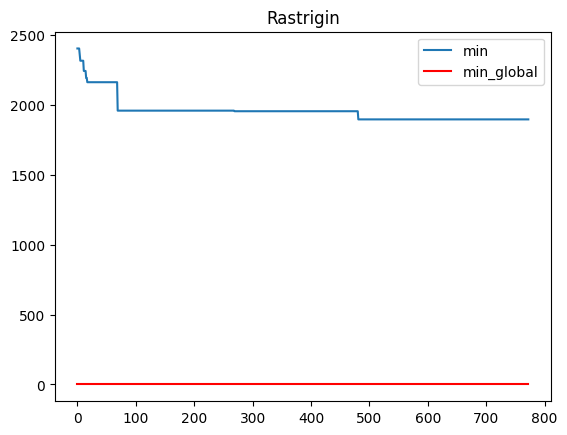

In [43]:
model = ES(domain, h, initial_population, offspring_size, RastriginWrapper, iterations, plus=True, parent_random=False)
best_individual, best_score, iter_min, iter_mean, iter_max = model.run()
indiv = np.dot(A, best_individual[0]) + b
print("Best individual mapped back to original space:" + str(indiv))
print(Rastrigin(indiv))
showcase(best_individual, best_score, iter_min, iter_mean, iter_max, "Rastrigin", 0)

In [53]:
#benchmark 3 Ackley function http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page295.htm
def Ackley(individual):
    d = len(individual)
    return -20*np.exp(-0.2*np.sqrt(np.sum(individual**2)/d)) - np.exp(np.sum(np.cos(2*np.pi*individual))/d) + 20 + np.exp(1)

domain = (-15, 30)
dims = 40
initial_population = 100
offspring_size = 700
iterations = 3

In [56]:
d = dims
h = 40000 * d
A = np.random.rand(d, h)
b = np.random.rand(d)

def AckleyWrapper(y):
    x = np.dot(A, y) + b 
    return Ackley(x)
domain = calculate_new_domain(domain, A, b, d, h)

100%|██████████| 3/3 [08:04<00:00, 161.53s/it]


Best individual mapped back to original space:[-0.06996825  0.01657924  0.18667463 -0.09837346  0.00697177 -0.01753532
 -0.10023066  0.02968669  0.02833702 -0.01504146 -0.11211979  0.03285495
 -0.01315805  0.21701625 -0.12453144 -0.05542629 -0.00063525  0.13543392
  0.22611628 -0.1361417   0.12723756 -0.10064067  0.01234575  0.03780275
 -0.00255714 -0.0597076  -0.10183596 -0.09653174  0.06352152 -0.0158762
  0.00437711 -0.13492514 -0.06483003  0.03744738  0.06522997 -0.04609339
 -0.08748979  0.05231177 -0.03723487  0.08208653]
0.744466462054707
Best individual: [ 0.00048381 -0.00042111 -0.00065557 ... -0.0002082  -0.00011249
  0.00036684]
Best score: 0.744466462054707


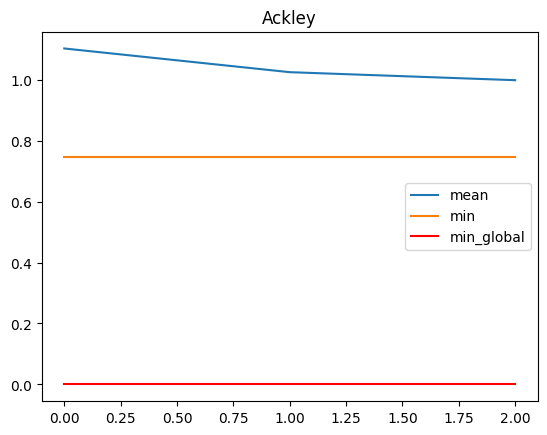

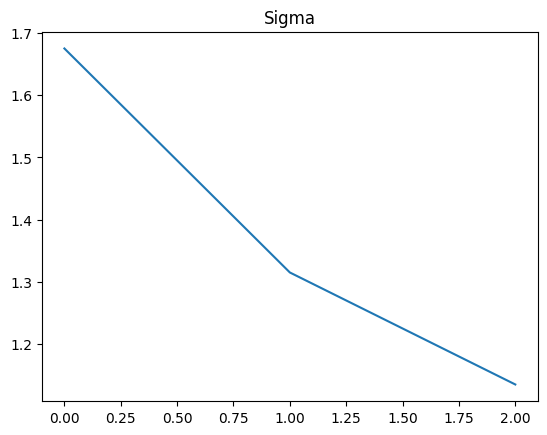

In [57]:
model = ES(domain, h, initial_population, offspring_size, AckleyWrapper, iterations, plus=True, parent_random=False)
best_individual, best_sigmas, best_score, iter_min, iter_mean, iter_max = model.run()
indiv = np.dot(A, best_individual[0]) + b
print("Best individual mapped back to original space:" + str(indiv))
print(Ackley(indiv))
showcase(best_individual, best_sigmas, best_score, iter_min, iter_mean, iter_max, "Ackley", 0)

  5%|▍         | 943/20000 [07:18<2:27:41,  2.15it/s]

Best individual mapped back to original space:[  6.63990872   6.958715    -0.14247716  -1.8598088   -4.5096467
   0.62079455  -4.07154463   6.28317036   2.10456654   3.56369201
  -5.13270842  -6.98930043   3.06471338   1.1820542   -1.55737437
  10.06808631  -0.84072219   2.73583605   2.34555128   2.85472247
  -7.61576176   3.64722766   2.24367923  -7.54566086   6.17975791
   9.56335016  -0.7576069   -0.90076358  -6.07489103   1.76182686
  -2.10677253  -5.28655708   3.70864757  -1.74420503  -2.61011435
   3.52670433 -15.5826271   -0.43065768   0.15788232  -4.6361065 ]
14.51087261754456
Best score: 14.51087261754456


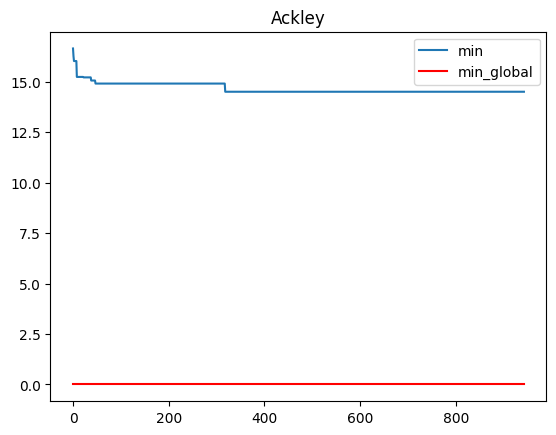

In [141]:
model = ES(domain, h, initial_population, offspring_size, AckleyWrapper, iterations, plus=True, parent_random=False)
best_individual, best_score, iter_min, iter_mean, iter_max = model.run()
indiv = np.dot(A, best_individual[0]) + b
print("Best individual mapped back to original space:" + str(indiv))
print(Ackley(indiv))
showcase(best_individual, best_score, iter_min, iter_mean, iter_max, "Ackley", 0)

In [58]:
#benchmark 4 Easom function http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page1361.htm
def Easom(individual):
    return -np.cos(individual[0])*np.cos(individual[1])*np.exp(-((individual[0]-np.pi)**2 + (individual[1]-np.pi)**2))

domain = (-100, 100)
dims = 2
initial_population = 100
offspring_size = 700
iterations = int(1e4)

In [ ]:
d = dims
h = 10 * d
A = np.random.rand(d, h)
b = np.random.rand(d)

def EasomWrapper(y):
    x = np.dot(A, y) + b 
    return Easom(x)
domain = calculate_new_domain(domain, A, b, d, h)

100%|██████████| 10000/10000 [02:35<00:00, 64.45it/s]


Best individual mapped back to original space:[3.14159266 3.14159265]
-1.0
Best score: -1.0


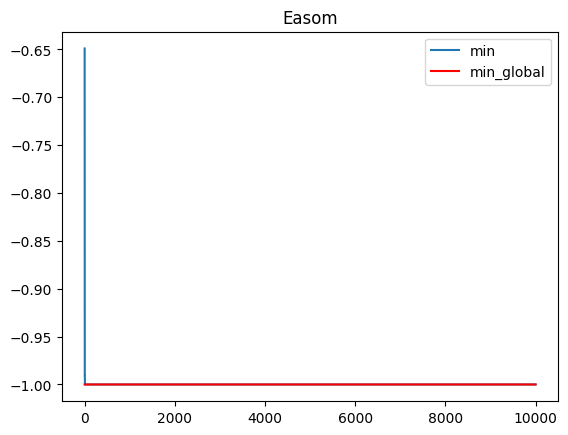

In [63]:
model = ES(domain, h, initial_population, offspring_size, EasomWrapper, iterations, plus=True, parent_random=False)
best_individual, best_score, iter_min, iter_mean, iter_max = model.run()
indiv = np.dot(A, best_individual[0]) + b
print("Best individual mapped back to original space:" + str(indiv))
print(Easom(indiv))
showcase(best_individual, best_score, iter_min, iter_mean, iter_max, "Easom", -1)

In [40]:
#benchmark 5 Schwefel function http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page2530.htm
def Schwefel(individual):
    d = len(individual)
    value = 418.9829*d
    for i in range(d):
        value -= individual[i] * np.sin(np.sqrt(np.abs(individual[i])))
    return value 

domain = (-500, 500)
dims = 30
initial_population = 4000
offspring_size = 21000
iterations = 1e4

In [ ]:
d = dims
h = 10 * d
A = np.random.rand(d, h)
b = np.random.rand(d)

def SchwefelWrapper(y):
    x = np.dot(A, y) + b 
    return Schwefel(x)
domain = calculate_new_domain(domain, A, b, d, h, 500, -500)

[498.24169435 505.18865945 502.23163328 469.87010856 496.68188622
 507.15513025 507.81322018 505.75065262 499.59147286 470.22033185
 483.96873024 492.04667954 521.06914767 476.98068192 489.10034856
 457.18454111 492.56506193 489.07074304 501.11792706 467.51524607
 470.33851412 513.638293   488.16673146 478.34891118 503.02189193
 480.21742105 458.96487472 493.31080915 502.06884951 486.46159609]


  1%|          | 60/10000 [01:29<4:06:53,  1.49s/it]


Best individual mapped back to original space:[-596.40046527 -259.44137399 -480.12109792 -296.84506418 -358.5912319
 -381.65984355 -393.49895103 -343.13690955 -597.22902421 -229.91140767
 -306.59540989 -281.26954429 -336.98709468 -568.41336338 -463.10940372
 -447.05547167 -411.75449055 -571.51413425 -500.61305097 -482.70486309
 -590.88873376 -432.79479028 -291.22820065 -351.09725883 -331.5887161
 -329.07884553 -249.13650966 -261.94572621 -271.09413175 -487.73554248]
125323.05448346456
Best individual: [-339.91505287 -255.65754984 -210.10588688]
Best score: 9898.666665780604


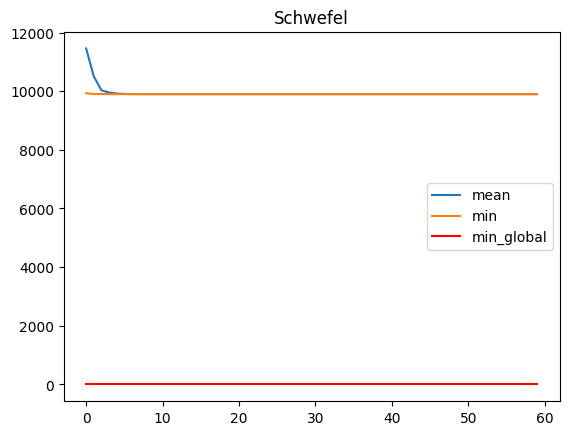

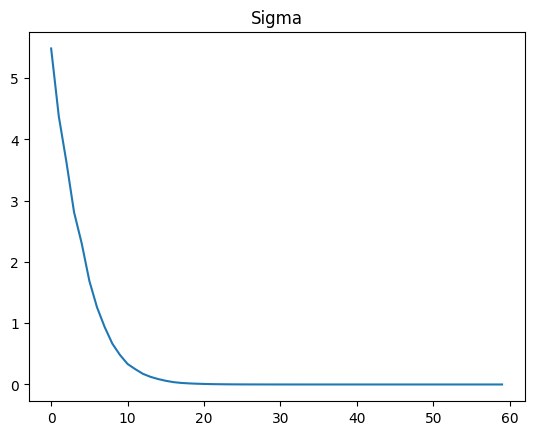

In [61]:
d = 3
h = dims 
A = np.random.rand(h, d)
b = np.random.rand(h)
def SchwefelWrapper3(y):
    x = np.dot(A, y) + b 
    return Schwefel(x)

domain = calculate_domain_from_h_to_d(domain, A, b, h, d, 500, -500)
model = ES(domain, d, initial_population, offspring_size, SchwefelWrapper3, iterations, plus=True, parent_random=False)
best_individual, best_sigmas, best_score, iter_min, iter_mean, iter_max = model.run()
indiv2 = np.dot(A, best_individual[0]) + b
print("Best individual mapped back to original space:" + str(indiv2))
print(Schwefel(indiv))
showcase(best_individual, best_sigmas, best_score, iter_min, iter_mean, iter_max, "Schwefel", 0)

  0%|          | 0/2 [05:53<?, ?it/s]


Best individual mapped back to original space:[2.16882342 2.29862532 2.45186804 2.59448304 2.5396977  2.12310699
 3.01092101 2.56813325 3.01893515 2.24235496 3.00448165 3.63646855
 2.82679086 2.95582641 2.56879451 3.08260105 2.35528186 2.80998659
 2.08974315 2.44735394 2.43165285 2.52314095 2.24009499 3.01159003
 2.43489244 2.30686025 2.20897466 2.88378128 3.09408667 2.55609675]
12491.639537227646
Best individual: [ 0.00205519  0.00303821  0.00126965 ... -0.00326284 -0.00360181
  0.00059651]
Best score: 12491.639537227646


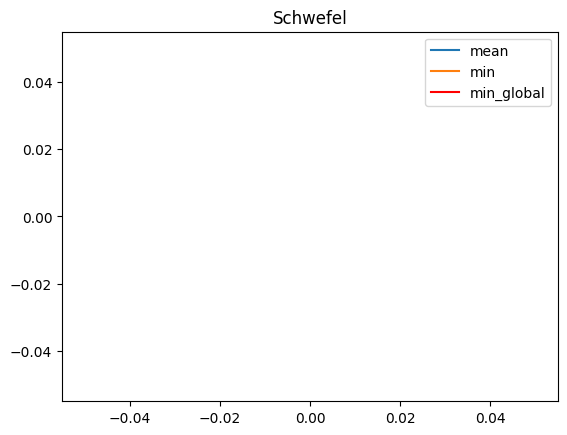

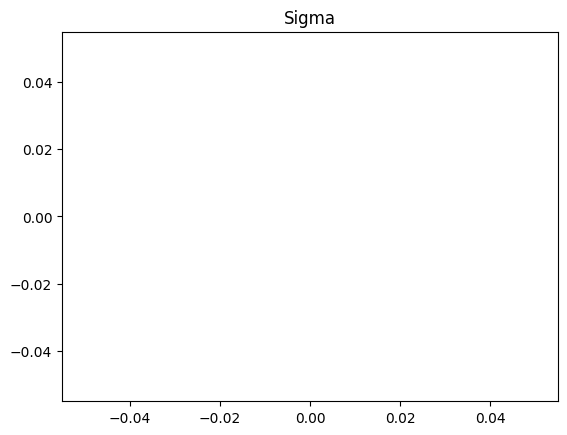

In [8]:
model = ES(domain, h, initial_population, offspring_size, SchwefelWrapper, iterations, plus=True, parent_random=False)
best_individual, best_sigmas, best_score, iter_min, iter_mean, iter_max = model.run()
indiv = np.dot(A, best_individual[0]) + b
print("Best individual mapped back to original space:" + str(indiv))
print(Schwefel(indiv))
showcase(best_individual, best_sigmas, best_score, iter_min, iter_mean, iter_max, "Schwefel", 0)

100%|██████████| 1000/1000 [06:25<00:00,  2.59it/s]

Best individual mapped back to original space:[61.11762904 55.52834617 64.88976209 59.12033966 57.52680365 74.37585621
 61.2604011  69.35383467 63.23463952 68.27559845 59.20923955 63.50592338
 65.58266086 53.18933551 56.91183812 54.97844367 66.142989   63.62040138
 53.82726086 60.17666059 45.94307205 62.94765886 55.97443308 59.29848624
 73.72175412 68.02347534 61.31743723 61.39525506 62.63808118 72.81987158]
10855.643664770136
Best score: 10855.643664770136


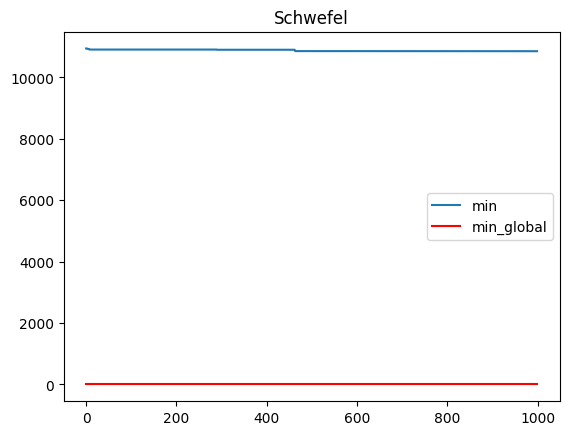

In [133]:
model = ES(domain, h, initial_population, offspring_size, SchwefelWrapper, iterations, plus=True, parent_random=False)
best_individual, best_score, iter_min, iter_mean, iter_max = model.run()
indiv = np.dot(A, best_individual[0]) + b
print("Best individual mapped back to original space:" + str(indiv))
print(Schwefel(indiv))
showcase(best_individual, best_score, iter_min, iter_mean, iter_max, "Schwefel", 0)